In [1]:
import glob
import tensorflow as tf
import numpy as np

import lead_binary

from collections import namedtuple

In [2]:
# model_path = './lead_model_jack/lead_jack-200000'
# model_path = './lead_model_jack2/lead_jack-1000000'
#model_path = './lead_model_jack3/lead_jack-1000000'
model_path = './lead_model_jack4/lead_jack-789000'

In [3]:
sess = tf.InteractiveSession()

In [4]:
saver = tf.train.import_meta_graph(model_path + '.meta')
saver.restore(sess, model_path)

INFO:tensorflow:Restoring parameters from ./lead_model_jack4/lead_jack-789000


In [5]:
keep_prob = sess.graph.get_tensor_by_name('keep_prob:0')
A = sess.graph.get_tensor_by_name('seq_in:0')
H = sess.graph.get_tensor_by_name('H:0')

# state_c_0 = sess.graph.get_tensor_by_name('state_c_0:0')
# state_h_0 = sess.graph.get_tensor_by_name('state_h_0:0')

# state_c_1 = sess.graph.get_tensor_by_name('state_c_1:0')
# state_h_1 = sess.graph.get_tensor_by_name('state_h_1:0')

#pred = sess.graph.get_tensor_by_name('Mul:0')
pred = sess.graph.get_tensor_by_name('pred:0')

In [6]:
def lead_iterator(fin):
    lines = []
    for i, line in enumerate(fin):
        line = line.strip()
        if i % 17 == 0 and i > 0:
            deal_str = lines[0]
            hands = list(map(lambda hand_str: list(map(list, hand_str.split('.'))), deal_str[2:].split()))
            deal_meta = lead_binary.DealMeta.from_str(lines[1])
            # auction
            padded_auction = (['PAD_START'] * deal_meta.get_n_pad_start()) + lead_binary.convert_auction(lines[2])
            n_pad_end = 4 - (len(padded_auction) % 4) if (len(padded_auction) % 4) > 0 else 0
            padded_auction = padded_auction + (['PAD_END'] * n_pad_end)
            padded_auction = padded_auction[:-4] if set(padded_auction[-4:]) == set(['PASS', 'PAD_END']) else padded_auction
            
            auction_ftrs = lead_binary.binary_auction(padded_auction)
            hand_ftrs = lead_binary.hand_features(hands, deal_meta)
            leader_hand = '.'.join(''.join(suit) for suit in hands[lead_binary.seat_index[deal_meta.leader()]])
            
                
            yield auction_ftrs, hand_ftrs, leader_hand, lines[1], lines[2], lines[3][:2]
            
            lines = []
        
        lines.append(line)

In [7]:
suits = ['S', 'H', 'D', 'C']
card_values = list('AKQJT98765432')

In [8]:
def get_card_str(card_index):
    return '%s%s' % (suits[card_index // 13], card_values[card_index % 13])

In [9]:
def get_top_leads(pred, k=5):
    score_i = sorted([(s, i) for i, s in enumerate(pred)], reverse=True)
    return [(get_card_str(i), s) for s, i in score_i[:k]]

In [48]:
# fnm_in = '../data/leads_raw/test/JOS_N.test.txt'
# fnm_out = 'leads_nt_listing_jos.txt'
# fnm_in = '../data/leads_raw/test/JOS_S.test.txt'
# fnm_out = 'leads_suit_listing_jos.txt'
# fnm_in = '../data/leads_raw/test/BW5C_S.test.txt'
# fnm_out = 'leads_suit_listing_bw5c.txt'
fnm_in = '../data/leads_raw/test/BW5C_N.test.txt'
fnm_out = 'leads_nt_listing_bw5c.txt'
fout = open(fnm_out, 'w')
n_hands = 1000

lead_it = lead_iterator(open(fnm_in))
for (i, (a, h, hand, outcome, auction, jack_lead)) in enumerate(lead_it):
    if i > n_hands:
        break
    
    
    p = sess.run(pred, feed_dict={A: a, H: h, keep_prob: 1.0})[0]
    
    top_lead = get_top_leads(p)[0][0]
    
    if top_lead != jack_lead:
        
        fout.write(outcome)
        fout.write('\n')
        fout.write(auction)
        fout.write('\n')
        fout.write(hand)
        fout.write('\n')
    
        fout.write(' %s\n' % jack_lead)
        for card, score in get_top_leads(p):
            fout.write('  %s %1.3f' % (card, score))

        fout.write('\n------------\n')

fout.close()

In [10]:
def small_card_x(card_str):
    if card_str[1] in ('7', '6', '5', '4', '3', '2'):
        return card_str[0] + 'x'
    return card_str

In [11]:
nn_leads = []
jack_leads = []
for fnm in glob.glob('../data/leads_raw/test/*.txt'):
    print(fnm)
    for a, h, hand, outcome, auction, jack_lead in lead_iterator(open(fnm)):
        a_zeros = np.zeros((1, 24, 40))
        #a = a_zeros
        p = sess.run(pred, feed_dict={A: a, H: h, keep_prob: 1.0})[0]
        
        nn_lead = small_card_x(get_top_leads(p)[0][0])
        nn_leads.append(nn_lead)
        jack_leads.append(small_card_x(jack_lead))

../data/leads_raw/test/BW5C_N.test.txt
../data/leads_raw/test/BW5C_S.test.txt
../data/leads_raw/test/JOS_N.test.txt
../data/leads_raw/test/JOS_S.test.txt


In [33]:
!wc -l ../data/leads_raw/test/JOS_N.test.txt

104278 ../data/leads_raw/test/JOS_N.test.txt


In [21]:
len(nn_leads), len(jack_leads)

(36906, 36906)

In [24]:
nn_leads[95625//17:(95625+155567)][:10]

[]

In [23]:
list(zip(nn_leads[95625:(95625+155567)], jack_leads[95625:(95625+155567)]))[:10]

[]

In [17]:
start_i, end_i = 0, 95625 // 17
#start_i, end_i = 95625 // 17, (95625 + 155567) // 17
#start_i, end_i = (95625 + 155567) // 17, (95625 + 155567 + 104278) // 17
#start_i, end_i = (95625 + 155567 + 104278) // 17, (95625 + 155567 + 104278 + 272000) // 17
print(sum((nn_lead == jack_lead) for nn_lead, jack_lead in zip(nn_leads[start_i:end_i], jack_leads[start_i:end_i])) / (end_i - start_i))
print(sum((nn_lead[0] == jack_lead[0]) for nn_lead, jack_lead in zip(nn_leads[start_i:end_i], jack_leads[start_i:end_i])) / (end_i - start_i))

0.7461333333333333
0.7937777777777778


In [12]:
sum((nn_lead == jack_lead) for nn_lead, jack_lead in zip(nn_leads, jack_leads)) / len(nn_leads)

0.7156017991654473

In [13]:
sum((nn_lead[0] == jack_lead[0]) for nn_lead, jack_lead in zip(nn_leads, jack_leads)) / len(nn_leads)

0.7528857096407088

In [18]:
list(zip(nn_leads, jack_leads))[:20]

[('DK', 'DK'),
 ('CT', 'CT'),
 ('Hx', 'Cx'),
 ('S9', 'S9'),
 ('CQ', 'Cx'),
 ('Hx', 'Cx'),
 ('CT', 'CT'),
 ('DT', 'Hx'),
 ('Sx', 'CT'),
 ('DT', 'DT'),
 ('Cx', 'Cx'),
 ('D8', 'D8'),
 ('Sx', 'Sx'),
 ('Sx', 'Sx'),
 ('Dx', 'Dx'),
 ('D8', 'Sx'),
 ('DK', 'DK'),
 ('Cx', 'Cx'),
 ('HK', 'HK'),
 ('Sx', 'SQ')]

In [15]:
def metric(predictions, costs):
    predicted_indexes = np.argmax(predictions, axis=1)
    result = []
    for i in range(len(predictions)):
        result.append(costs[i, predicted_indexes[i]])
        
    return result


In [16]:
L = np.load('../data/leads_bin2/L_val.npy')
C = np.load('../data/leads_bin2/C_val.npy')

In [17]:
losses = metric(L, C)

In [18]:
np.mean(losses)

0.33936

In [19]:
import matplotlib.pyplot as plt

In [20]:
%matplotlib inline

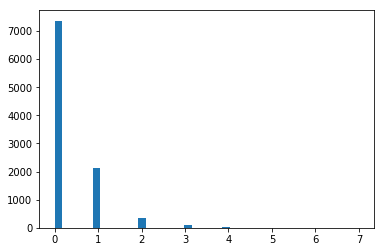

In [21]:
plt.hist(losses, 40);

In [31]:
A_val = np.load('../data/leads_bin2/A_val.npy')
H_val = np.load('../data/leads_bin2/H_val.npy')

In [32]:
A_val.shape, H_val.shape

((10000, 24, 40), (10000, 70))

In [19]:
sess.run(pred, feed_dict={
    A: A_val[:2, :, :], 
    H: H_val[:2, :],
    keep_prob: 1.0
})

array([[ 0.        ,  0.        ,  0.1566782 ,  0.03503932,  0.        ,
         0.00051358,  0.00073965,  0.        ,  0.00077453,  0.00222775,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01199078,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.00696403,  0.        ,  0.01082721,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.00281614,
         0.        ,  0.0148021 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.00149825,  0.00252849,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.00341247,
         0.        ,  0.0021444 ,  0.00141141,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.03810577,  0.        ,
         0.     

In [30]:
A_val.shape

NameError: name 'A_val' is not defined